In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv('D:/Major Project/Dataset/Dynamics/A1237_25deg.csv')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23450 entries, 0 to 23449
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Current(A)      23450 non-null  float64
 1   Voltage(V)      23450 non-null  float64
 2   Temperature(C)  23450 non-null  float64
 3   OCV             23450 non-null  float64
 4   SOC             23450 non-null  float64
dtypes: float64(5)
memory usage: 916.1 KB


In [5]:
data.head()

,Current(A),Voltage(V),Temperature(C),OCV,SOC
0,0.000000,2.766393,26.788187,2.766393,31.0
1,-1.099373,2.501398,26.818743,2.490405,8.0
2,-1.099185,2.435226,26.818743,2.424235,2.0
3,0.000000,2.460464,26.893473,2.460464,5.0
4,0.000000,2.474314,26.713451,2.474314,6.0


In [6]:
data.describe()

,Current(A),Voltage(V),Temperature(C),OCV,SOC
count,23450.000000,23450.000000,23450.000000,23450.000000,23450.000000
mean,-0.390197,3.192579,27.240275,3.188677,65.714670
std,0.934397,0.191681,0.239510,0.199467,16.625459
min,-3.849407,2.409681,26.427921,2.401217,0.000000
25%,-0.901211,3.106793,27.083542,3.099524,58.000000
50%,-0.369649,3.209128,27.205795,3.205703,67.000000
75%,0.000378,3.296922,27.355192,3.297616,75.000000
max,2.061261,3.591540,28.366453,3.599771,100.000000


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [8]:
x = data.iloc[:,:-2]
y = data.iloc[:,-1]

In [9]:
scaler = MinMaxScaler()
x = scaler.fit_transform(x)

In [10]:
x = x.reshape(23450,3,1)

In [11]:
x

array([[[0.65126431],
        [0.30182295],
        [0.18584463]],

       [[0.4652663 ],
        [0.07760423],
        [0.20160693]],

       [[0.46529808],
        [0.02161456],
        [0.20160693]],

       ...,

       [[0.54334562],
        [0.10989586],
        [0.52739659]],

       [[0.48312571],
        [0.04713546],
        [0.52739659]],

       [[0.65126431],
        [0.17838544],
        [0.45752689]]])

In [12]:
y = np.array(y).reshape(23450,1)

In [13]:
y

array([[31.],
       [ 8.],
       [ 2.],
       ...,
       [11.],
       [ 5.],
       [18.]])

In [14]:
train_input, test_input, train_soc, test_soc = train_test_split(x,y,test_size=0.2, random_state=42)

In [15]:
for i in range(len(train_soc)):
    if train_soc[i] == 0:
        train_soc[i] = 1

In [16]:
for i in range(len(test_soc)):
    if test_soc[i] == 0:
        test_soc[i] = 1

In [17]:
train_input.shape

(18760, 3, 1)

In [18]:
test_input.shape

(4690, 3, 1)

In [19]:
train_soc.shape

(18760, 1)

In [20]:
test_soc.shape

(4690, 1)

In [21]:
from keras.models import Sequential
from keras.layers import  Dense, RepeatVector, TimeDistributed, GRU,Flatten
from keras.optimizers import Adam,SGD,RMSprop

In [22]:
# Define the model
model = Sequential()

# Encoder
model.add(Dense(16, input_shape=(3,1),activation='tanh'))
model.add(Dense(32, activation='tanh'))
model.add(Dense(64, activation='tanh'))
model.add(Flatten())

# Repeat the context vector to be the input for the decoder
model.add(RepeatVector(1))

# Decoder
model.add(GRU(64, return_sequences=True,activation='sigmoid'))
model.add(GRU(32, return_sequences=True,activation='sigmoid'))
model.add(GRU(16, return_sequences=True,activation='sigmoid'))
model.add(TimeDistributed(Dense(1, activation='linear')))  # Output sequence for regression

In [23]:
# Compile the model with optimizer and loss function
model.compile(optimizer='adam', loss='mse',metrics=['mae'])

In [24]:
# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 3, 16)             32        
                                                                 
 dense_1 (Dense)             (None, 3, 32)             544       
                                                                 
 dense_2 (Dense)             (None, 3, 64)             2112      
                                                                 
 flatten (Flatten)           (None, 192)               0         
                                                                 
 repeat_vector (RepeatVecto  (None, 1, 192)            0         
 r)                                                              
                                                                 
 gru (GRU)                   (None, 1, 64)             49536     
                                                        

In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score,mean_absolute_percentage_error
import time

In [26]:
# Train the model
a1 = time.time()
history = model.fit(train_input, train_soc, epochs=500, batch_size=256,validation_split=0.05)
a2 = time.time()
a = a2-a1

Epoch 1/500
70/70 [==============================] - 5s 15ms/step - loss: 4476.8174 - mae: 64.8116 - val_loss: 4333.1992 - val_mae: 63.8635
Epoch 2/500
70/70 [==============================] - 0s 6ms/step - loss: 4220.9062 - mae: 62.8104 - val_loss: 4170.3276 - val_mae: 62.5765
Epoch 3/500
70/70 [==============================] - 0s 6ms/step - loss: 4094.5576 - mae: 61.8003 - val_loss: 4061.7351 - val_mae: 61.7045
Epoch 4/500
70/70 [==============================] - 0s 7ms/step - loss: 3992.7546 - mae: 60.9751 - val_loss: 3964.2239 - val_mae: 60.9109
Epoch 5/500
70/70 [==============================] - 1s 7ms/step - loss: 3898.8984 - mae: 60.2042 - val_loss: 3872.5923 - val_mae: 60.1556
Epoch 6/500
70/70 [==============================] - 0s 7ms/step - loss: 3809.7766 - mae: 59.4636 - val_loss: 3784.8086 - val_mae: 59.4244
Epoch 7/500
70/70 [==============================] - 1s 7ms/step - loss: 3723.9089 - mae: 58.7418 - val_loss: 3699.8428 - val_mae: 58.7081
Epoch 8/500
70/70 [=======

70/70 [==============================] - 0s 6ms/step - loss: 1005.1525 - mae: 28.7248 - val_loss: 987.4344 - val_mae: 28.4765
Epoch 60/500
70/70 [==============================] - 0s 6ms/step - loss: 976.4816 - mae: 28.2664 - val_loss: 958.7802 - val_mae: 28.0126
Epoch 61/500
70/70 [==============================] - 0s 6ms/step - loss: 948.5403 - mae: 27.8136 - val_loss: 930.8409 - val_mae: 27.5516
Epoch 62/500
70/70 [==============================] - 0s 6ms/step - loss: 921.3181 - mae: 27.3656 - val_loss: 903.6285 - val_mae: 27.0951
Epoch 63/500
70/70 [==============================] - 0s 6ms/step - loss: 894.7891 - mae: 26.9225 - val_loss: 877.1111 - val_mae: 26.6428
Epoch 64/500
70/70 [==============================] - 0s 6ms/step - loss: 868.9820 - mae: 26.4846 - val_loss: 851.1948 - val_mae: 26.1951
Epoch 65/500
70/70 [==============================] - 0s 6ms/step - loss: 843.8323 - mae: 26.0508 - val_loss: 826.1082 - val_mae: 25.7546
Epoch 66/500
70/70 [==========================

70/70 [==============================] - 1s 9ms/step - loss: 279.5924 - mae: 12.5346 - val_loss: 259.1136 - val_mae: 12.2391
Epoch 119/500
70/70 [==============================] - 1s 9ms/step - loss: 278.9094 - mae: 12.4935 - val_loss: 258.3894 - val_mae: 12.2021
Epoch 120/500
70/70 [==============================] - 1s 8ms/step - loss: 278.3540 - mae: 12.4590 - val_loss: 257.7436 - val_mae: 12.1658
Epoch 121/500
70/70 [==============================] - 1s 10ms/step - loss: 277.8919 - mae: 12.4268 - val_loss: 257.2104 - val_mae: 12.1329
Epoch 122/500
70/70 [==============================] - 1s 9ms/step - loss: 277.5144 - mae: 12.3988 - val_loss: 256.7977 - val_mae: 12.1050
Epoch 123/500
70/70 [==============================] - 1s 8ms/step - loss: 277.2123 - mae: 12.3722 - val_loss: 256.4243 - val_mae: 12.0774
Epoch 124/500
70/70 [==============================] - 1s 9ms/step - loss: 276.9652 - mae: 12.3498 - val_loss: 256.1400 - val_mae: 12.0543
Epoch 125/500
70/70 [===================

70/70 [==============================] - 1s 7ms/step - loss: 276.1097 - mae: 12.2102 - val_loss: 254.7682 - val_mae: 11.9193
Epoch 178/500
70/70 [==============================] - 1s 7ms/step - loss: 276.1194 - mae: 12.2211 - val_loss: 254.7825 - val_mae: 11.9223
Epoch 179/500
70/70 [==============================] - 1s 7ms/step - loss: 276.1049 - mae: 12.2161 - val_loss: 254.7762 - val_mae: 11.9210
Epoch 180/500
70/70 [==============================] - 1s 8ms/step - loss: 276.1067 - mae: 12.2111 - val_loss: 254.7745 - val_mae: 11.9207
Epoch 181/500
70/70 [==============================] - 1s 9ms/step - loss: 276.1100 - mae: 12.2094 - val_loss: 254.7731 - val_mae: 11.9203
Epoch 182/500
70/70 [==============================] - 1s 8ms/step - loss: 276.1073 - mae: 12.2142 - val_loss: 254.7719 - val_mae: 11.9201
Epoch 183/500
70/70 [==============================] - 1s 7ms/step - loss: 276.1059 - mae: 12.2140 - val_loss: 254.7825 - val_mae: 11.9223
Epoch 184/500
70/70 [====================

70/70 [==============================] - 1s 9ms/step - loss: 1.8624 - mae: 0.5775 - val_loss: 1.2971 - val_mae: 0.5047
Epoch 238/500
70/70 [==============================] - 1s 9ms/step - loss: 1.7364 - mae: 0.5882 - val_loss: 1.2724 - val_mae: 0.5825
Epoch 239/500
70/70 [==============================] - 1s 9ms/step - loss: 1.5672 - mae: 0.5452 - val_loss: 1.0854 - val_mae: 0.4762
Epoch 240/500
70/70 [==============================] - 1s 7ms/step - loss: 1.4284 - mae: 0.5215 - val_loss: 0.9631 - val_mae: 0.4382
Epoch 241/500
70/70 [==============================] - 1s 7ms/step - loss: 1.3135 - mae: 0.5097 - val_loss: 0.8832 - val_mae: 0.4270
Epoch 242/500
70/70 [==============================] - 1s 8ms/step - loss: 1.2099 - mae: 0.5006 - val_loss: 0.7999 - val_mae: 0.4090
Epoch 243/500
70/70 [==============================] - 1s 9ms/step - loss: 1.0990 - mae: 0.4758 - val_loss: 0.7394 - val_mae: 0.4082
Epoch 244/500
70/70 [==============================] - 1s 9ms/step - loss: 1.0212 -

70/70 [==============================] - 1s 10ms/step - loss: 0.1238 - mae: 0.2852 - val_loss: 0.1916 - val_mae: 0.3508
Epoch 299/500
70/70 [==============================] - 1s 10ms/step - loss: 0.1168 - mae: 0.2789 - val_loss: 0.0951 - val_mae: 0.2550
Epoch 300/500
70/70 [==============================] - 1s 8ms/step - loss: 0.1168 - mae: 0.2790 - val_loss: 0.0943 - val_mae: 0.2564
Epoch 301/500
70/70 [==============================] - 1s 9ms/step - loss: 0.1146 - mae: 0.2771 - val_loss: 0.1418 - val_mae: 0.3073
Epoch 302/500
70/70 [==============================] - 1s 10ms/step - loss: 0.1060 - mae: 0.2688 - val_loss: 0.0912 - val_mae: 0.2525
Epoch 303/500
70/70 [==============================] - 1s 10ms/step - loss: 0.1141 - mae: 0.2774 - val_loss: 0.1491 - val_mae: 0.3154
Epoch 304/500
70/70 [==============================] - 1s 10ms/step - loss: 0.1084 - mae: 0.2719 - val_loss: 0.1000 - val_mae: 0.2629
Epoch 305/500
70/70 [==============================] - 1s 9ms/step - loss: 0.1

70/70 [==============================] - 1s 9ms/step - loss: 0.1039 - mae: 0.2709 - val_loss: 0.0960 - val_mae: 0.2633
Epoch 360/500
70/70 [==============================] - 1s 10ms/step - loss: 0.0968 - mae: 0.2633 - val_loss: 0.0935 - val_mae: 0.2603
Epoch 361/500
70/70 [==============================] - 1s 9ms/step - loss: 0.0993 - mae: 0.2658 - val_loss: 0.1191 - val_mae: 0.2798
Epoch 362/500
70/70 [==============================] - 1s 9ms/step - loss: 0.0978 - mae: 0.2646 - val_loss: 0.0951 - val_mae: 0.2618
Epoch 363/500
70/70 [==============================] - 1s 9ms/step - loss: 0.1068 - mae: 0.2734 - val_loss: 0.0958 - val_mae: 0.2616
Epoch 364/500
70/70 [==============================] - 1s 9ms/step - loss: 0.1035 - mae: 0.2703 - val_loss: 0.1372 - val_mae: 0.2987
Epoch 365/500
70/70 [==============================] - 1s 8ms/step - loss: 0.1078 - mae: 0.2743 - val_loss: 0.0839 - val_mae: 0.2455
Epoch 366/500
70/70 [==============================] - 1s 8ms/step - loss: 0.1099 

70/70 [==============================] - 1s 9ms/step - loss: 0.1018 - mae: 0.2676 - val_loss: 0.0976 - val_mae: 0.2655
Epoch 421/500
70/70 [==============================] - 1s 10ms/step - loss: 0.0980 - mae: 0.2650 - val_loss: 0.0852 - val_mae: 0.2508
Epoch 422/500
70/70 [==============================] - 1s 9ms/step - loss: 0.0980 - mae: 0.2641 - val_loss: 0.0967 - val_mae: 0.2618
Epoch 423/500
70/70 [==============================] - 1s 9ms/step - loss: 0.1103 - mae: 0.2759 - val_loss: 0.0944 - val_mae: 0.2553
Epoch 424/500
70/70 [==============================] - 1s 10ms/step - loss: 0.0930 - mae: 0.2594 - val_loss: 0.0894 - val_mae: 0.2528
Epoch 425/500
70/70 [==============================] - 1s 11ms/step - loss: 0.1030 - mae: 0.2701 - val_loss: 0.0842 - val_mae: 0.2487
Epoch 426/500
70/70 [==============================] - 1s 10ms/step - loss: 0.0952 - mae: 0.2613 - val_loss: 0.0990 - val_mae: 0.2667
Epoch 427/500
70/70 [==============================] - 1s 10ms/step - loss: 0.0

70/70 [==============================] - 1s 12ms/step - loss: 0.1072 - mae: 0.2739 - val_loss: 0.1116 - val_mae: 0.2748
Epoch 482/500
70/70 [==============================] - 1s 9ms/step - loss: 0.0939 - mae: 0.2599 - val_loss: 0.0912 - val_mae: 0.2544
Epoch 483/500
70/70 [==============================] - 1s 10ms/step - loss: 0.1066 - mae: 0.2727 - val_loss: 0.1065 - val_mae: 0.2673
Epoch 484/500
70/70 [==============================] - 1s 10ms/step - loss: 0.1153 - mae: 0.2808 - val_loss: 0.1140 - val_mae: 0.2757
Epoch 485/500
70/70 [==============================] - 1s 11ms/step - loss: 0.1016 - mae: 0.2688 - val_loss: 0.0848 - val_mae: 0.2500
Epoch 486/500
70/70 [==============================] - 1s 11ms/step - loss: 0.0994 - mae: 0.2659 - val_loss: 0.1002 - val_mae: 0.2633
Epoch 487/500
70/70 [==============================] - 1s 9ms/step - loss: 0.1070 - mae: 0.2733 - val_loss: 0.1148 - val_mae: 0.2822
Epoch 488/500
70/70 [==============================] - 1s 10ms/step - loss: 0.

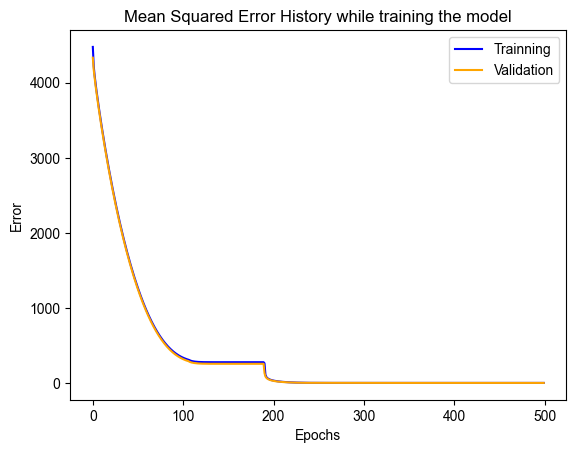

In [27]:
plt.plot(history.history['loss'],color='blue',label='Trainning')
plt.plot(history.history['val_loss'],color='orange',label='Validation')
plt.title('Mean Squared Error History while training the model')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
sns.set_style('whitegrid')
plt.show()

In [28]:
# Make predictions
predictions = model.predict(test_input)

147/147 [==============================] - 1s 2ms/step


In [29]:
predictions.shape

(4690, 1, 1)

In [30]:
test_soc.shape

(4690, 1)

In [31]:
test_soc = test_soc.reshape(4690,)
y_pred = predictions.reshape(4690,)

In [32]:
mse = mean_squared_error(test_soc, y_pred)
mae = mean_absolute_error(test_soc, y_pred)
rmse = math.sqrt(mse)
mape = mean_absolute_percentage_error(test_soc,y_pred)
r2 = r2_score(test_soc, y_pred)

In [33]:
print(f'Mean Squared Error on Test Set: {mse}')
print(f'Root Mean Squared Error on Test Set: {rmse}')
print(f'Mean Absolute Error on Test Set: {mae}')
print(f'Mean Absolute Percentage Error on Test Set: {mape*100}')
print(f'R2 Score : {r2}')

Mean Squared Error on Test Set: 0.08893396888070225
Root Mean Squared Error on Test Set: 0.2982179888616752
Mean Absolute Error on Test Set: 0.25497943495890735
Mean Absolute Percentage Error on Test Set: 0.45675252813627
R2 Score : 0.9996842012508266


In [34]:
print(f'Time taken for fitting the model is {a/60} mins')

Time taken for fitting the model is 5.322824227809906 mins


In [35]:
Residual = test_soc - y_pred

In [36]:
df = pd.DataFrame({'Actual': test_soc , 'Predicted': y_pred}).sort_values('Actual',ascending=False)
df.head()

,Actual,Predicted
1938,100.0,99.617676
624,100.0,99.639778
1759,99.0,98.895035
2045,99.0,98.905624
1096,99.0,98.693771


In [37]:
df.tail()

,Actual,Predicted
3079,3.0,2.903359
1715,2.0,1.985664
2135,2.0,2.126238
4095,2.0,2.231238
4493,1.0,1.305889


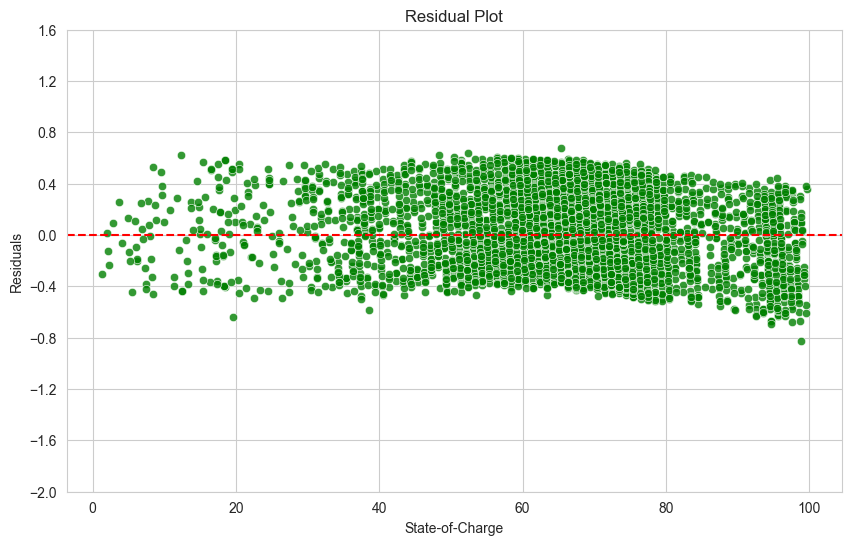

In [38]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=Residual, color='green', alpha=0.8)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('State-of-Charge')
plt.ylabel('Residuals')
plt.ylim(-1.6, 1)  # Set y-axis limits
plt.yticks([i * 0.4 for i in range(-5, 5)])  # Set y-axis ticks
plt.show()

In [39]:
# Save the model to a file
model.save("25deg.h5")